<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/train_validation_test_split/train_test_split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
import numpy as np

In [80]:
SAMPLE_CSV_PATH = "/MyDrive/amazon_rainforest_files/amazon_sample_data/2023_06_23_Results_Google.csv" #@param
FEATURE_COLUMNS = ["Code", "Origin", "lat", "long", "VPD", "RH", "PET", "DEM", "PA"] #@param
LABEL_COLUMNS = ["d18O_cel"] #@param

# The columns that will be used to group the dataset to calculate
# means and variance on LABEL_COLUMNS
GROUPING_COLUMNS = ["Code"] #@param
# If True, the rows will remain unique GROUPING_COLUMNS values. Otherwise
# we merge the grouping columns aggregates with the original dataset.
KEEP_GROUPING = True #@param

# Values can be:
# - SORTING: Sample rows are sorted by key made of PARTITION_COLUMNS
PARTITION_STRATEGY = "FIXED" #@param
assert(PARTITION_STRATEGY in ['FIXED'])

# For FIXED only, the bounds of each partition for the split
# train = df[(df["lat"] >= -5) & (df["lon"] > -62.5)]
# test = df[(df["lat"] < -5)]
# validation = df[(df["lat"] >= -5) & (df["lon"] <= -62.5)]
TRAIN_FIXED_BOUNDS = [(-5, -62.5), (float('inf'), float('inf'))]
VALIDATION_FIXED_BOUNDS = [(-5, float('-inf')), (float('inf'), -62.5)]
TEST_FIXED = BOUNDS = [(float('-inf'), float('-inf')), (-5, float('inf'))]
TRAIN_VALIDATION_TEST_BOUNDS = [TRAIN_FIXED_BOUNDS, VALIDATION_FIXED_BOUNDS, TEST_FIXED]

OUTPUT_TRAIN_CSV_PATH = "/MyDrive/amazon_rainforest_files/amazon_sample_data/luis_train_grouped.csv" #@param
OUTPUT_VALIDATION_CSV_PATH = "/MyDrive/amazon_rainforest_files/amazon_sample_data/luis_validation.csv" #@param
OUTPUT_TEST_CSV_PATH = "/MyDrive/amazon_rainforest_files/amazon_sample_data/luis_validation.csv" #@param

GDRIVE_BASE = "/content/drive" #@param

In [3]:
# Access data stored on Google Drive
if GDRIVE_BASE:
    from google.colab import drive
    drive.mount(GDRIVE_BASE)

Mounted at /content/drive


In [67]:
def load_sample_data(df, feature_columns, label_columns, aggregate_columns, keep_grouping) -> pd.DataFrame:
  df = df[feature_columns + label_columns]

  if aggregate_columns:
    grouped = df.groupby(aggregate_columns)

    for col in label_columns:
      means = grouped.mean().reset_index()
      means.rename(columns={col: f"{col}_mean"}, inplace=True)
      means = means[aggregate_columns + [f"{col}_mean"]]

      variances = grouped.var().reset_index()
      variances.rename(columns={col: f"{col}_variance"}, inplace=True)
      variances = variances[aggregate_columns + [f"{col}_variance"]]

      df = pd.merge(df, means, how="inner", left_on=aggregate_columns, right_on=aggregate_columns)
      df = pd.merge(df, variances, how="inner", left_on=aggregate_columns, right_on=aggregate_columns)
      df.drop(columns=[col], inplace=True)

    if keep_grouping:
      # The first entry is the same as all entries in the grouping for the
      # aggregate_columns. Any other column will have different values but
      # we only take the first one.
      df = df.groupby(aggregate_columns).first().reset_index()

  return df

# (Optional) Test load_sample_data

In [79]:

from pandas.util.testing import assert_frame_equal

# Average and variance test
def average_variance_test():
  test_df = pd.DataFrame({
      "lat": [0.0, 0.0, 1.0],
      "long": [3.0, 3.0, 6.0],
      "x": [3.0, 3.0, 3.0],
      "y": [8.0, 0.0, -3.0]}
  )
  feature_columns = ["lat", "long"]
  label_columns = ["x", "y"]
  aggregate_columns = ["lat", "long"]
  keep_grouping=True

  test_sample = load_sample_data(test_df, feature_columns, label_columns, aggregate_columns, keep_grouping)
  expected_df = pd.DataFrame({
      "lat": [0.0, 1.0],
      "long": [3.0, 6.0],
      "x_mean": [3.0, 3.0],
      "x_variance": [0.0, np.nan],
      "y_mean": [4.0, -3.0],
      "y_variance": [32.0, np.nan]
  })
  assert_frame_equal(expected_df, test_sample)

def average_variance_test_no_grouping():
  test_df = pd.DataFrame({
      "lat": [0.0, 0.0, 1.0],
      "long": [3.0, 3.0, 6.0],
      "x": [3.0, 3.0, 3.0],
      "y": [8.0, 0.0, -3.0]}
  )
  feature_columns = ["lat", "long"]
  label_columns = ["x", "y"]
  aggregate_columns = ["lat", "long"]
  keep_grouping=False

  test_sample = load_sample_data(test_df, feature_columns, label_columns, aggregate_columns, keep_grouping)
  expected_df = pd.DataFrame({
      "lat": [0.0, 0.0, 1.0],
      "long": [3.0, 3.0, 6.0],
      "x_mean": [3.0, 3.0, 3.0],
      "x_variance": [0.0, 0.0, np.nan],
      "y_mean": [4.0, 4.0, -3.0],
      "y_variance": [32.0, 32.0, np.nan]
  })
  assert_frame_equal(expected_df, test_sample)

def average_variance_test_keep_nonnumerical_columns():
  test_df = pd.DataFrame({
      "code": ["a", "b", "c"],
      "lat": [0.0, 0.0, 1.0],
      "long": [3.0, 3.0, 6.0],
      "x": [3.0, 3.0, 3.0],
      "y": [8.0, 0.0, -3.0]}
  )
  feature_columns = ["code", "lat", "long"]
  label_columns = ["x", "y"]
  aggregate_columns = ["lat", "long"]
  keep_grouping=True

  test_sample = load_sample_data(test_df, feature_columns, label_columns, aggregate_columns, keep_grouping)
  expected_df = pd.DataFrame({
      "lat": [0.0, 1.0],
      "long": [3.0, 6.0],
      "code": ["a", "c"],
      "x_mean": [3.0, 3.0],
      "x_variance": [0.0, np.nan],
      "y_mean": [4.0, -3.0],
      "y_variance": [32.0, np.nan]
  })
  print(test_sample)
  assert_frame_equal(expected_df, test_sample)

average_variance_test()
average_variance_test_no_grouping()
average_variance_test_keep_nonnumerical_columns()

   lat  long code  x_mean  x_variance  y_mean  y_variance
0  0.0   3.0    a     3.0         0.0     4.0        32.0
1  1.0   6.0    c     3.0         NaN    -3.0         NaN


<ipython-input-67-a24c8fc89bae>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = grouped.mean().reset_index()
<ipython-input-67-a24c8fc89bae>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  variances = grouped.var().reset_index()
<ipython-input-67-a24c8fc89bae>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = grouped.mean().reset_index()
<ipython-input-67-a24c8fc89bae>:12: FutureWarning: The default v

# Load Sample

In [5]:
df = pd.read_csv(f"{GDRIVE_BASE}/{SAMPLE_CSV_PATH}", encoding="ISO-8859-1", sep=',')
sample_data = load_sample_data(df, FEATURE_COLUMNS, LABEL_COLUMNS, GROUPING_COLUMNS, KEEP_GROUPING)

<ipython-input-4-2e92aa900481>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = grouped.mean().reset_index()
<ipython-input-4-2e92aa900481>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  variances = grouped.var().reset_index()


In [6]:
print(sample_data.shape)
sample_data

(220, 11)


,Code,lat,long,VPD,RH,PET,DEM,PA,d18O_cel_mean,Origin,d18O_cel_variance
0,mad0,-0.121000,-67.013000,0.58917,0.83284,91.16666,101.0,1000.89270,23.405260,sao gabriel da cachoeira,0.148275
1,mad01,-0.041000,-66.872000,0.62083,0.82559,92.27500,93.0,1001.84741,25.725845,sao gabriel da cachoeira,0.213718
2,mad1,-3.995545,-57.589273,0.85167,0.77358,99.99167,61.0,1005.67358,26.748000,maues,0.532670
3,mad10,-0.121230,-67.013103,0.58917,0.83284,91.16666,101.0,1000.89270,25.936000,sao_gabriel_cachoeira,0.066530
4,mad100,-3.992300,-54.908000,0.70750,0.80339,97.88333,108.0,1000.05792,26.862000,santarem,0.489970
...,...,...,...,...,...,...,...,...,...,...,...
215,madsd06,-0.121230,-67.013103,0.58917,0.83284,91.16666,101.0,1000.89270,25.682000,sÃ£o gabriel da cachoeira,0.944720
216,madsd07,-4.303698,-70.291068,0.73583,0.79822,89.56667,108.0,1000.05792,24.028000,atalia do norte,0.458520
217,madsd08,-6.009707,-61.868657,0.77083,0.79509,93.97500,71.0,1004.47662,23.944000,manicorÃ©,0.158130
218,madsd09,-3.758534,-66.073754,0.64667,0.82247,90.44167,84.0,1002.92230,23.752000,Jurua,0.524370


In [7]:
def partition_data_fixed(sample_data, train_validation_test_bounds):
  '''
  Return data split between the fixed rectangle train_validation_test_bounds
  of lattitude and longitude for each of the rows in sample_data.
  '''
  train_bounds = train_validation_test_bounds[0]
  validation_bounds = train_validation_test_bounds[1]
  test_bounds = train_validation_test_bounds[2]

  train_data = sample_data[
      (sample_data['lat'] >= train_bounds[0][0]) & (sample_data['long'] >= train_bounds[0][1]) &
      (sample_data['lat'] <= train_bounds[1][0]) & (sample_data['long'] <= train_bounds[1][1])]
  validation_data = sample_data[
      (sample_data['lat'] >= validation_bounds[0][0]) & (sample_data['long'] >= validation_bounds[0][1]) &
      (sample_data['lat'] <= validation_bounds[1][0]) & (sample_data['long'] <= validation_bounds[1][1])]
  test_data = sample_data[
      (sample_data['lat'] >= test_bounds[0][0]) & (sample_data['long'] >= test_bounds[0][1]) &
      (sample_data['lat'] <= test_bounds[1][0]) & (sample_data['long'] <= test_bounds[1][1])]

  return train_data, validation_data, test_data

In [8]:
if PARTITION_STRATEGY == "FIXED":
  train_data, validation_data, test_data = partition_data_fixed(sample_data, TRAIN_VALIDATION_TEST_BOUNDS)
else:
  raise ValueError(f"Unknown partition strategy: {PARTITION_STRATEGY}")

In [9]:
print(train_data.shape[0])
print(validation_data.shape[0])
print(test_data.shape[0])

73
41
106


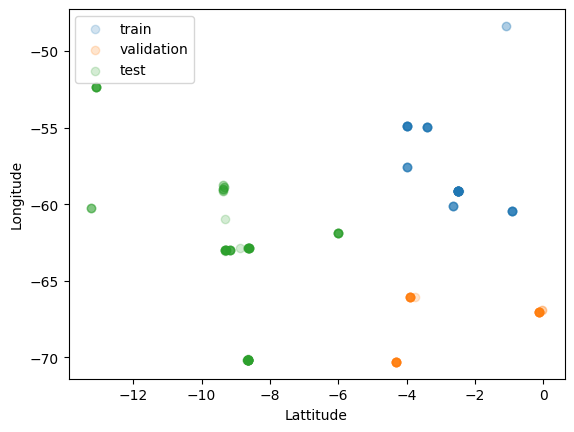

In [11]:
# Optional (plot splits)
import matplotlib
import matplotlib.pyplot as plt

plt.scatter(train_data["lat"], train_data["long"], label="train", alpha=0.2)
plt.scatter(validation_data["lat"], validation_data["long"], label="validation", alpha=0.2)
plt.scatter(test_data["lat"], test_data["long"], label="test", alpha=0.2)
plt.xlabel('Lattitude')
plt.ylabel('Longitude')
plt.legend()
plt.show()

In [12]:
train_data.to_csv(f"{GDRIVE_BASE}{OUTPUT_TRAIN_CSV_PATH}")
validation_data.to_csv(f"{GDRIVE_BASE}{OUTPUT_VALIDATION_CSV_PATH}")
test_data.to_csv(f"{GDRIVE_BASE}{OUTPUT_TEST_CSV_PATH}")